In [22]:
# discussion and overview of workflow process here https://aws.amazon.com/blogs/machine-learning/build-tune-and-deploy-an-end-to-end-churn-prediction-model-using-amazon-sagemaker-pipelines/
# most of the actual code is referenced from https://github.com/aws-samples/customer-churn-sagemaker-pipelines-sample/blob/main/Customer_Churn_Modeling.ipynb

# have to run these the first time, and then restart the kernel; not part of vanilla install
#!pip install s3fs
#!pip install shap
#!pip install smdebug

import re
import boto3
import pandas as pd
import numpy as np
import s3fs
import shap
from pprint import pprint
import time
from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
import smdebug
from sagemaker.inputs import TrainingInput
from sagemaker.session import Session
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial

print(f"SageMaker SDK version: {sagemaker.__version__}")
print(f"SageMaker Debug version: {smdebug.__version__}")


SageMaker SDK version: 2.227.0
SageMaker Debug version: 1.0.34


In [2]:
# Preprocess the dataset
def preprocess_data(file_path):  
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()    
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df


## Set the required configurations
# s3://cust-retention-project/storedata_total.csv

model_name = "churn_model"
env = "dev"
## S3 Bucket
default_bucket = "cust-retention-project"
## Preprocess the dataset
storedata = preprocess_data(f"s3://{default_bucket}/storedata_total.csv")
storedata


,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30796,1,6,83.333333,16.666667,55.68,0.000000,1,0,1,0,...,False,False,False,False,False,False,False,False,False,True
30797,1,13,69.230769,7.692308,35.00,0.000000,1,0,0,0,...,False,True,False,False,False,False,False,False,False,True
30798,1,8,75.000000,37.500000,52.03,0.500000,1,1,0,4,...,False,True,False,False,False,False,False,False,False,True
30799,1,6,33.333333,0.000000,40.20,0.000000,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False


In [3]:

def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test = np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names, train, validation, test

# Split dataset
feature_names, train, validation, test = split_datasets(storedata)

# Save datasets in Amazon S3
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/test/test.csv", header=False, index=False)

print(train.shape)
print(validation.shape)
print(test.shape)


(21530, 22)
(4614, 22)
(4614, 22)


In [5]:

# Training and Validation Input for SageMaker Training job
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/train/", content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/validation/", content_type="csv")

# Hyperparameter used
fixed_hyperparameters = {
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "num_round": "100",
    "rate_drop": "0.3",
    "tweedie_variance_power": "1.4"
}

# Use the built-in SageMaker algorithm
sess = sagemaker.Session()

# this container is retrieving the Amazon SageMaker Docker image URI for the specified framework (xgboost), AWS region, and version (0.90-2)
region = "us-east-2"
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

# have to pass the ARN of the role explicitly, this IAM role must have the permissions needed for SageMaker to access S3, ECR, and other AWS services.
# have to dig it up for this instance, or try to get it from the studio session data
# role = "arn:aws:iam::123456789012:role/service-role/AmazonSageMaker-ExecutionRole"
role = sagemaker.get_execution_role()

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess
)

hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

objective_metric_name = "validation:auc"

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=2 )

# Tune
tuner.fit({
    "train" : s3_input_train,
    "validation" : s3_input_validation
    }, include_cls_metadata=False )

## Explore the best model generated
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)
## 10 training jobs have completed


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................!
10 training jobs have completed


In [6]:
## Get the best training job

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")



Best Model found so far:
{'CreationTime': datetime.datetime(2024, 11, 26, 23, 57, 37, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9848750233650208},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 11, 26, 23, 58, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:412381776958:training-job/sagemaker-xgboost-241126-2354-005-85685554',
 'TrainingJobName': 'sagemaker-xgboost-241126-2354-005-85685554',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 11, 26, 23, 57, 41, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.7081621927537323',
                          'eta': '0.29994725292823055',
                          'max_depth': '4',
                          'min_child_weight': '4.60306208405202'}}


ML-4931-HyperParameterTuning

After you establish a baseline, you can use Amazon SageMaker Debugger for offline model analysis. Debugger is a capability within SageMaker that automatically provides visibility into the model training process for real-time and offline analysis. Debugger saves the internal model state at periodic intervals, which you can analyze in real time during training and offline after the training is complete. For this use case, you use the explainability tool SHAP (SHapley Additive exPlanation) and the native integration of SHAP with Debugger. Refer to the following notebook for detailed analysis.

The following summary plot explains the positive and negative relationships of the predictors with the target variable. For example, the top variable here, esent, is defined as number of emails sent. This plot is made of all data points in the training set. Blue indicates dragging the final output to class 0, and pink represents class 1. Key influencing features are ranked in descending order.


In [7]:
best_hyperparams = tuning_job_result['BestTrainingJob']['TunedHyperParameters']
best_hyperparams

{'alpha': '1.7081621927537323',
 'eta': '0.29994725292823055',
 'max_depth': '4',
 'min_child_weight': '4.60306208405202'}

XGBoost Model with SageMaker Debugger

In [8]:
hyperparameters = {**fixed_hyperparameters, **best_hyperparams}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [9]:
estimator.fit({"train": s3_input_train, "validation": s3_input_validation}, wait=False )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-11-27-01-03-35-427


In [12]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation 

In [13]:
estimator.latest_training_job.rule_job_summary()


[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:412381776958:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-c92a4895',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 70 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2024, 11, 27, 1, 6, 27, 342000, tzinfo=tzlocal())}]

In [14]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)


[2024-11-27 01:09:30.220 default:230 INFO s3_trial.py:42] Loading trial debug-output at path s3://cust-retention-project/debugger/demo-smdebug-xgboost-churn-classificati-2024-11-27-01-03-35-427/debug-output


In [15]:
trial.tensor_names()


[2024-11-27 01:09:33.040 default:230 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-27 01:09:34.058 default:230 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [16]:
trial.tensor("average_shap/f1").values()

{0: array([1.5752454e-05], dtype=float32),
 5: array([0.01214081], dtype=float32),
 10: array([0.00196656], dtype=float32),
 15: array([0.03987117], dtype=float32),
 20: array([0.05479405], dtype=float32),
 25: array([0.07775891], dtype=float32),
 30: array([0.10580559], dtype=float32),
 35: array([0.0910273], dtype=float32),
 40: array([0.09049693], dtype=float32),
 45: array([0.09232704], dtype=float32),
 50: array([0.09277547], dtype=float32),
 55: array([0.08749426], dtype=float32),
 60: array([0.08368494], dtype=float32),
 65: array([0.0839546], dtype=float32),
 70: array([0.08903798], dtype=float32),
 75: array([0.09288908], dtype=float32),
 80: array([0.09523807], dtype=float32),
 85: array([0.09528958], dtype=float32),
 90: array([0.09675418], dtype=float32),
 95: array([0.10445843], dtype=float32)}

In [23]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

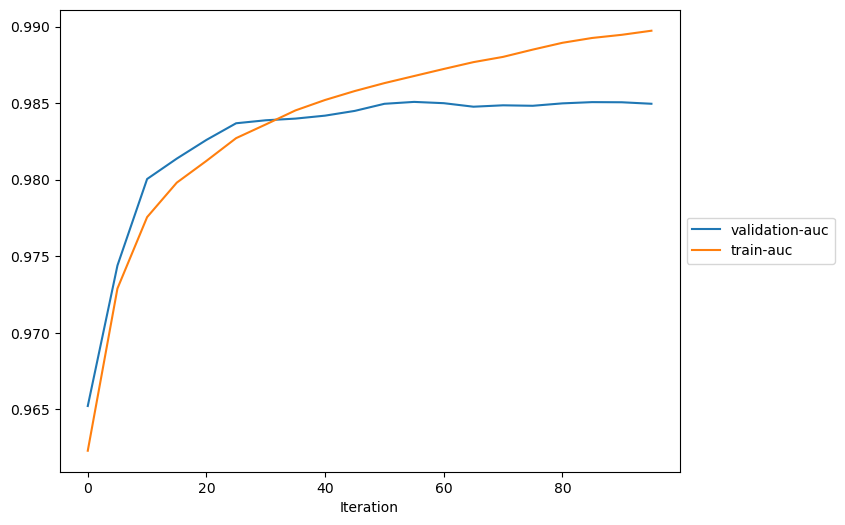

In [24]:
plot_collection(trial, "metrics")

In [25]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

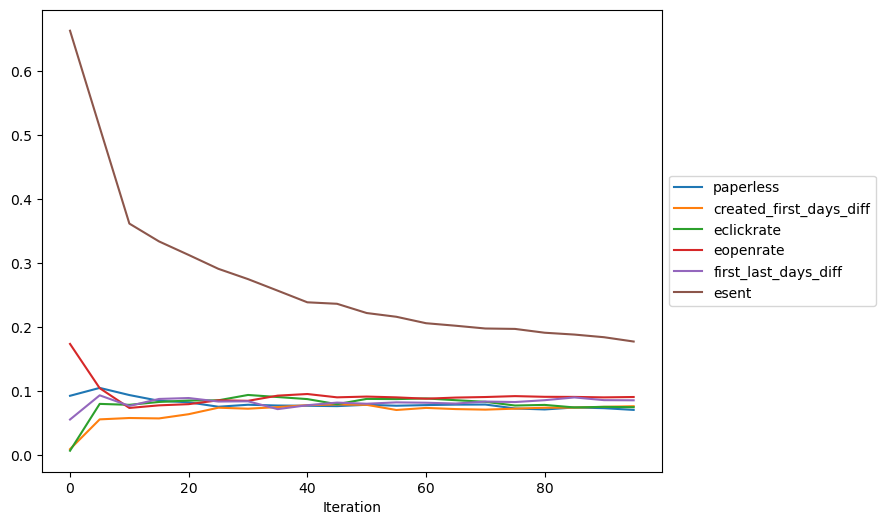

In [26]:
plot_feature_importance(trial, importance_type="cover")

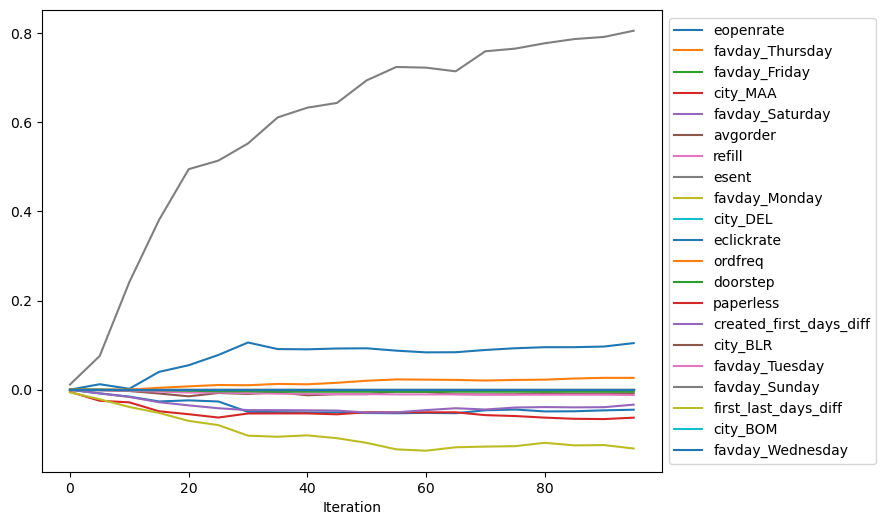

In [33]:
plot_collection(trial, "average_shap")

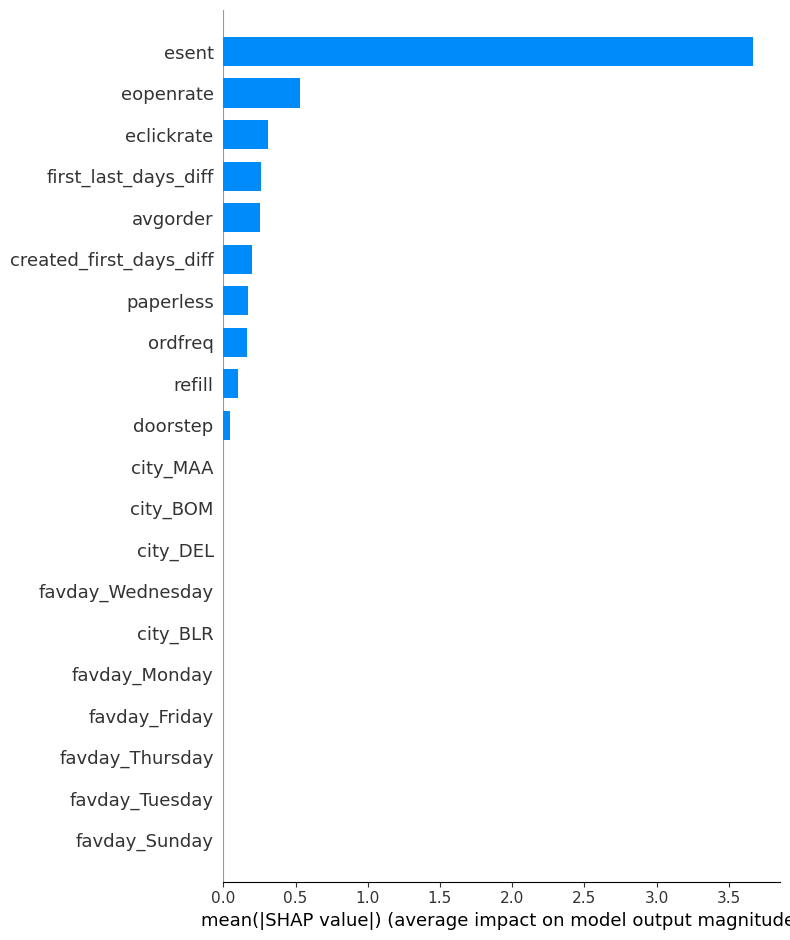

In [34]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [35]:
shap_base_value

2.122415

In [36]:
train_shap = pd.DataFrame(train[:,1:], columns=feature_names)

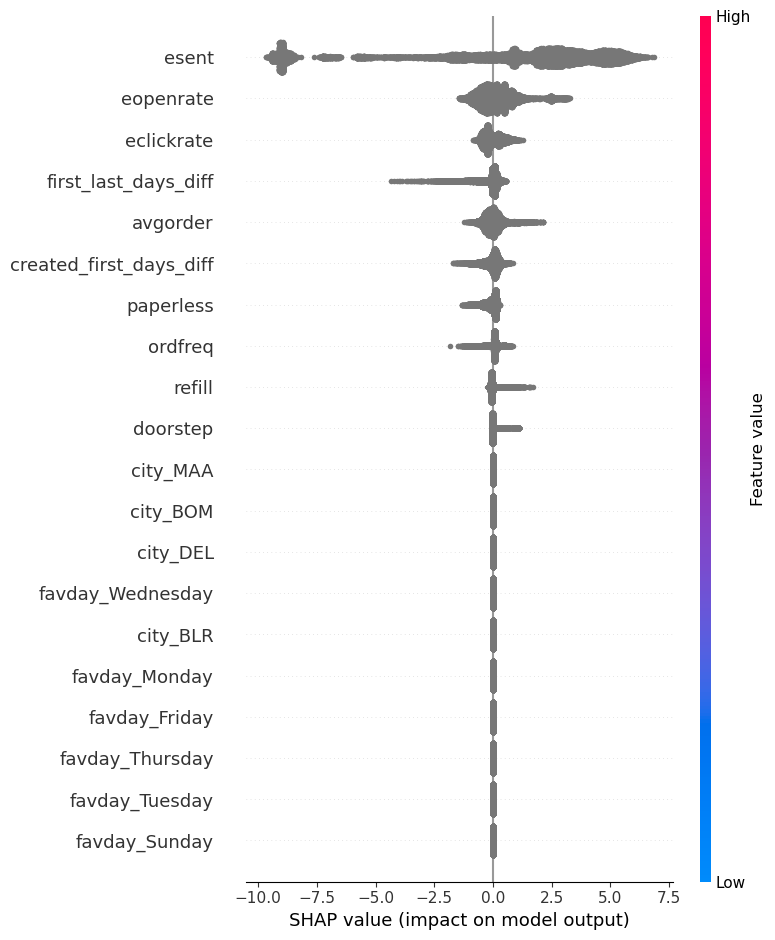

In [37]:
# from reference notebook at https://github.com/aws-samples/customer-churn-sagemaker-pipelines-sample
shap.summary_plot(shap_no_base, train_shap)

ML-4931-Shapley-Plots

Now you can proceed with the deploy and manage step of the ML workflow.
Develop and automate the workflow

Let’s start with the project structure:

    /customer-churn-model – Project name
    /data – Dataset
    /pipelines – Code for SageMaker pipeline components
    SageMaker_Pipelines_project.ipynb – Allows you to create and run the ML workflow
    Customer_Churn_Modeling.ipynb – Baseline model development notebook

ML-4931-projectstructure

Under <project-name>/pipelines/customerchurn, you can see the following Python scripts:

    Preprocess.py – Integrates with SageMaker Processing for feature engineering
    Evaluate.py – Allows model metrics calculation, in this case auc_score
    Generate_config.py – Allows dynamic configuration needed for the downstream Clarify job for model explainability
    Pipeline.py – Templatized code for the Pipelines ML workflow

ML-4931-CodeStructure

Let’s walk through every step in the DAG and how they run. The steps are similar to when we first prepared the data.
Perform data readiness with the following code:


In [ ]:
# processing step for feature engineering
    sklearn_processor = SKLearnProcessor(
        framework_version="0.23-1",
        instance_type=processing_instance_type,
        instance_count=processing_instance_count,
        sagemaker_session=sagemaker_session,
        role=role,
    )
    step_process = ProcessingStep(
        name="ChurnModelProcess",
        processor=sklearn_processor,
        inputs=[
          ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  
        ],
        outputs=[
            ProcessingOutput(output_name = "train", source="/opt/ml/processing/train",
                             destination = f"s3://{default_bucket}/output/train" ),
            ProcessingOutput(output_name = "validation", source="/opt/ml/processing/validation",
                            destination = f"s3://{default_bucket}/output/validation"),
            ProcessingOutput(output_name = "test", source="/opt/ml/processing/test",
                            destination = f"s3://{default_bucket}/output/test")
        ],
        code=f"s3://{default_bucket}/input/code/preprocess.py",
    )

# Train, tune, and find the best candidate model:

# training step for generating model artifacts
    model_path = f"s3://{default_bucket}/output"
    image_uri = sagemaker.image_uris.retrieve(
        framework="xgboost",
        region=region,
        version="1.0-1",
        py_version="py3",
        instance_type=training_instance_type,
    )
    fixed_hyperparameters = {
        "eval_metric":"auc",
        "objective":"binary:logistic",
        "num_round":"100",
        "rate_drop":"0.3",
        "tweedie_variance_power":"1.4"
    }
    xgb_train = Estimator(
        image_uri=image_uri,
        instance_type=training_instance_type,
        instance_count=1,
        hyperparameters=fixed_hyperparameters,
        output_path=model_path,
        base_job_name=f"churn-train",
        sagemaker_session=sagemaker_session,
        role=role,
    )
    hyperparameter_ranges = {
        "eta": ContinuousParameter(0, 1),
        "min_child_weight": ContinuousParameter(1, 10),
        "alpha": ContinuousParameter(0, 2),
        "max_depth": IntegerParameter(1, 10),
    }
    objective_metric_name = "validation:auc"



You can add a model tuning step (TuningStep) in the pipeline, which automatically invokes a hyperparameter tuning job (see the following code). The hyperparameter tuning finds the best version of a model by running many training jobs on the dataset using the algorithm and the ranges of hyperparameters that you specified. You can then register the best version of the model into the model registry using the RegisterModel step.


In [ ]:
## Direct Integration for HPO

    step_tuning = TuningStep(
        name = "ChurnHyperParameterTuning",
        tuner = HyperparameterTuner(xgb_train, objective_metric_name, hyperparameter_ranges, max_jobs=2, max_parallel_jobs=2),
        inputs = {
                "train": TrainingInput(
                    s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
            },
        )



 ML-4931-SM_PipelineHPO

After you tune the model, depending on the tuning job objective metrics, you can use branching logic when orchestrating the workflow. For this post, the conditional step for model quality check is as follows:


In [ ]:
# condition step for evaluating model quality and branching execution
    cond_lte = ConditionGreaterThan(
        left=JsonGet(
            step=step_eval,
            property_file=evaluation_report,
            json_path="classification_metrics.auc_score.value"
        ),
        right=0.75,
    )

# The best candidate model is registered for batch scoring using the RegisterModel step:

step_register = RegisterModel(
        name="RegisterChurnModel",
        estimator=xgb_train,
        model_data=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=default_bucket,prefix="output"),
        content_types=["text/csv"],
        response_types=["text/csv"],
        inference_instances=["ml.t2.medium", "ml.m5.large"],
        transform_instances=["ml.m5.large"],
        model_package_group_name=model_package_group_name,
        model_metrics=model_metrics,
    )



Now that the model is trained, let’s see how Clarify helps us understand what features the models base their predictions on. You can create an analysis_config.json file dynamically per workflow run using the generate_config.py utility. You can version and track the config file per pipeline runId and store it in Amazon S3 for further references. Initialize the dataconfig and modelconfig files as follows:


In [ ]:

data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=f's3://{args.default_bucket}/output/train/train.csv',
    s3_output_path=args.bias_report_output_path,
        label=0,
        headers= ['target','esent','eopenrate','eclickrate','avgorder','ordfreq','paperless','refill','doorstep','first_last_days_diff','created_first_days_diff','favday_Friday','favday_Monday','favday_Saturday','favday_Sunday','favday_Thursday','favday_Tuesday','favday_Wednesday','city_BLR','city_BOM','city_DEL','city_MAA'],
        dataset_type="text/csv",
    )
    model_config = sagemaker.clarify.ModelConfig(
        model_name=args.modelname,
        instance_type=args.clarify_instance_type, 
        instance_count=1,
        accept_type="text/csv",
    )
    model_predicted_label_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)
    bias_config = sagemaker.clarify.BiasConfig(
        label_values_or_threshold=[1],
        facet_name="doorstep",
        facet_values_or_threshold=[0],
    )



After you add the Clarify step as a postprocessing job using sagemaker.clarify.SageMakerClarifyProcessor in the pipeline, you can see a detailed feature and bias analysis report per pipeline run.

ML-4931-ClarifyReport

ML-4931-SM-UI-1

ML-4931-SM-UI-2

As the final step of the pipeline workflow, you can use the TransformStep step for offline scoring. Pass in the transformer instance and the TransformInput with the batch_data pipeline parameter defined earlier:



In [ ]:
# step to perform batch transformation
transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{default_bucket}/ChurnTransform"
)

step_transform = TransformStep(
    name="ChurnTransform",
    transformer=transformer,
    inputs=TransformInput(data=batch_data,content_type="text/csv")
)



Finally, you can trigger a new pipeline run by choosing Start an execution on the Studio IDE interface.

ML-4931-SMPipeline-Execution

You can also describe a pipeline run or start the pipeline using the following notebook. The following screenshot shows our output.

ML-4931-SMPipeline-DescribeExecution

You can schedule your SageMaker model building pipeline runs using Amazon EventBridge. SageMaker model building pipelines are supported as a target in Amazon EventBridge. This allows you to trigger your pipeline to run based on any event in your event bus. EventBridge enables you to automate your pipeline runs and respond automatically to events such as training job or endpoint status changes. Events include a new file being uploaded to your S3 bucket, a change in status of your SageMaker endpoint due to drift, and Amazon Simple Notification Service (Amazon SNS) topics.
Conclusion

This post explained how to use SageMaker Pipelines with other built-in SageMaker features and the XGBoost algorithm to develop, iterate, and deploy the best candidate model for churn prediction. For instructions on implementing this solution, see the GitHub repo. You can also clone and extend this solution with additional data sources for model retraining. We encourage you to reach out and discuss your ML use cases with your AWS account manager.
Additional references

For additional information, see the following resources:

    Predicting Customer Churn with Amazon Machine Learning
    Building, automating, managing, and scaling ML workflows using Amazon SageMaker Pipelines
    ML Explainability with Amazon SageMaker Debugger

About the Authors

Gayatri Ghanakota is a Machine Learning Engineer with AWS Professional Services. She is passionate about developing, deploying, and explaining AI/ ML solutions across various domains. Prior to this role, she led multiple initiatives as a data scientist and ML engineer with top global firms in the financial and retail space. She holds a master’s degree in Computer Science specialized in Data Science from the University of Colorado, Boulder.

Sarita Joshi is a Senior Data Scientist with AWS Professional Services focused on supporting customers across industries including retail, insurance, manufacturing, travel, life sciences, media and entertainment, and financial services. She has several years of experience as a consultant advising clients across many industries and technical domains, including AI, ML, analytics, and SAP. Today, she is passionately working with customers to develop and implement machine learning and AI solutions at scale.